In [41]:
import torch, pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter

folder = '/home/dgotzens/shares/messdaten/000_Products/iMCR/2024-04-25_Channel-Antenna-Gain_LD_dgs/'
data = torch.stack(torch.load(folder+f'hcs-3m_data.pt'),-1)


In [42]:
M,K,L = data.shape
N_fft = 2**16
R_max = 50
dist = 3
f_s,T_s = 22e6, 1/22e6
f_0, f_1 = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
c_0 = 299_792_458

omegadot = 2*torch.pi*(f_1-f_0)/t_chirp

from matplotlib.ticker import EngFormatter, FuncFormatter

def distance_offsets(y, N=N_fft, D=dist, d=0.5, R=R_max):
    M,K,L = y.shape
    window = torch.hann_window(M)
    window /= window.sum()
    n_min = int((D-d)/R*N)
    n_max = int((D+d)/R*N)
    print(n_min,n_max)
    N_interp = 6

    dists = torch.empty(K)

    for k in range(K):
        fft = torch.fft.fft(window[:,None] * y[:,k,:], n=N, dim=0).mean(-1)
        n_refl = fft[n_min:n_max].abs().argmax() + n_min

        # use "center of square magnitude" (COSM) for frequency estimation
        vals = fft[n_refl-N_interp//2:n_refl+N_interp//2].abs().square()
        n_cosm = (torch.arange(n_refl-N_interp//2,n_refl+N_interp//2)*vals).sum()/vals.sum()

        dists[k]=n_cosm/N*R
    
    return dists - dists[0]

def gain_offsets(y, N=N_fft, D=dist, d=0.5, R=R_max):
    M,K,L = y.shape
    window = torch.hann_window(M)
    window /= window.sum()
    n_min = int((D-d)/R*N)
    n_max = int((D+d)/R*N)
    print(n_min,n_max)
    N_interp = 6

    gain = torch.empty(K, dtype=torch.cfloat)

    for k in range(K):
        fft = torch.fft.fft(window[:,None] * y[:,k,:], n=N, dim=0).mean(-1)
        n_refl = fft[n_min:n_max].abs().argmax() + n_min
        gain[k] = fft[n_refl]
    
    return gain


In [43]:
delta_tau =  2*distance_offsets(data)/c_0
frequency_correction = torch.exp(-1j*omegadot*delta_tau*torch.arange(M)[:,None]*T_s)

3276 4587


In [44]:
delta_tau_corrected = 2*distance_offsets(data*frequency_correction[:,:,None])/c_0

3276 4587


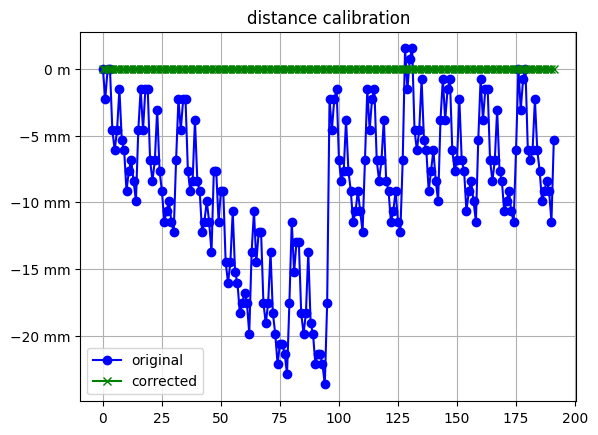

In [45]:
plt.plot(0.5*c_0*delta_tau, 'bo-', label='original')
plt.plot(0.5*c_0*delta_tau_corrected, 'gx-', label='corrected')
plt.title('distance calibration')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(EngFormatter('m'))
plt.show()

In [46]:
offs = gain_offsets(data*frequency_correction[:,:,None])
offs_corrected = gain_offsets(data*frequency_correction[:,:,None]/offs[:,None])


3276 4587
3276 4587


In [51]:
torch.save(frequency_correction/offs, folder+'hcs-3m_calib.pt')

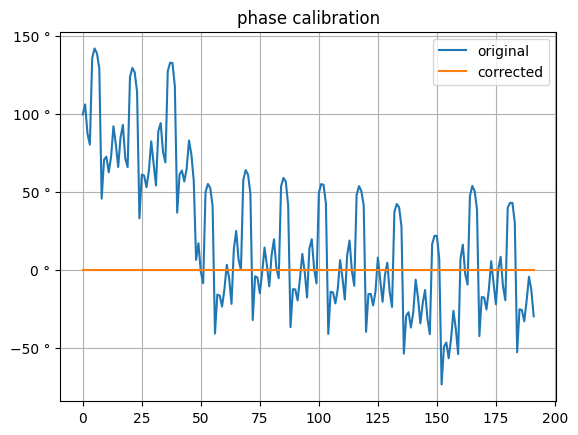

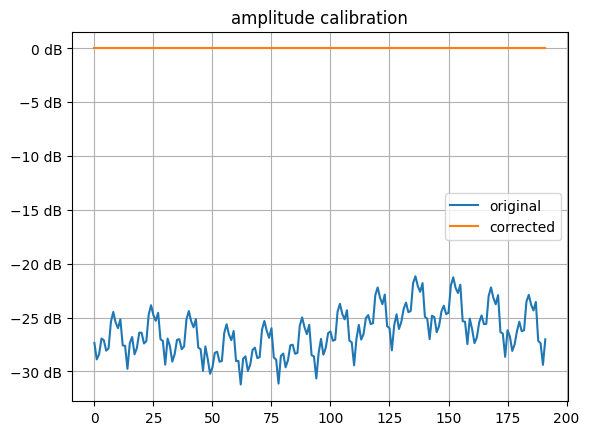

In [50]:
plt.title('phase calibration')
plt.plot(offs.angle()*180/3.14159, label='original')
plt.plot(offs_corrected.angle()*180/3.14159, label='corrected')
plt.gca().yaxis.set_major_formatter(EngFormatter('°'))
plt.grid()
plt.legend()
plt.show()

plt.title('amplitude calibration')
plt.plot(20*offs.abs().log10(), label='original')
plt.plot(20*offs_corrected.abs().log10(), label='corrected')
plt.gca().yaxis.set_major_formatter(EngFormatter('dB'))
plt.grid()
plt.legend()
plt.show()
